In [15]:
import torch
from torch import Tensor, LongTensor
import torch.nn as nn
from torch.nn import Module
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from data import  CornellVocab, CornellMovie, OpenSubVocab, OpenSub, sort_batch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from utils import parse, length_to_mask, masked_cross_entropy_loss, save_checkpoint
from tensorboardX import SummaryWriter
from seq import Encoder, Decoder, run
from inference import Beam
import os
import sys
import random
from time import strftime, localtime, time
from torch.nn.functional import softmax, log_softmax
import progressbar
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
%matplotlib inline

In [2]:
args = {
    "epoch":20,
    "batch_size":2,
    "num_workers":4,
    "train_path":"../data/train/2020_train",
    "test_path":"../data/dev/2020_dev",
    "vocab_size":25000,
    "embed_size":1000,
    "hidden_size":1000,
    "num_layers":4,
    "clip_thresh":1,
    "seed":1,
    "lr":0.1,
    "global_max_target_len":20,
    "cuda":torch.cuda.is_available,
    "resume":"checkpoint-29999",
    "dir":"final",
    "reverse": False,
    "vocab_path":"../data/movie_25000",
    "dropout":0.2,
    "beam_size":5
}
class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value
args = AttributeDict(args)

In [3]:
assert args.resume is not None
torch.manual_seed(args.seed)
if args.cuda: torch.cuda.manual_seed(args.seed)

cuda_prompt = "you are using cuda." if args.cuda else "you are not using cuda."
print("start model building, "+cuda_prompt)
vocab = OpenSubVocab(args.vocab_path)
test_data = OpenSub(args, vocab, args.test_path)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=args.batch_size,
                                          shuffle=True, collate_fn=sort_batch,
                                          num_workers=args.num_workers, pin_memory=True)
print("finish data loading.")

#beam_search(encoder, decoder, test_loader, args.beam_size, vocab, args.alpha, args.n_best, 20, args.cuda, None)
# greedy(test_loader, encoder, decoder, args.cuda)

start model building, you are using cuda.
finish data loading.


In [4]:
encoder = Encoder(args, test_data.source_vocab.vocab_size).cuda() if args.cuda else Encoder(args, test_data.source_vocab.vocab_size)
decoder = Decoder(args, test_data.target_vocab.vocab_size).cuda() if args.cuda else Decoder(args, test_data.target_vocab.vocab_size)
checkpoint = torch.load(os.path.join(args.dir, args.resume))
encoder.load_state_dict(checkpoint['encoder_state'])
decoder.load_state_dict(checkpoint['decoder_state'])

In [5]:
encoder_reverse = Encoder(args, test_data.source_vocab.vocab_size).cuda() if args.cuda else Encoder(args, test_data.source_vocab.vocab_size)
decoder_reverse = Decoder(args, test_data.target_vocab.vocab_size).cuda() if args.cuda else Decoder(args, test_data.target_vocab.vocab_size)
checkpoint = torch.load(os.path.join("final_reverse", args.resume))
encoder_reverse.load_state_dict(checkpoint['encoder_state'])
decoder_reverse.load_state_dict(checkpoint['decoder_state'])

In [6]:
from collections import Counter
import math
def ngram_precision(prediction, reference, n):
    """
    predictions: T list
    reference: Txn list
    """
    prediction = prediction.view(-1).tolist()
    reference = reference.view(-1).tolist()
    p_ngrams = [tuple(prediction[i:i+n]) for i in range(len(prediction)+1-n)]
    r_ngrams = [tuple(reference[i:i+n]) for i in range(len(reference)+1-n)]
    p_ngrams_counts = Counter(p_ngrams)
    r_ngrams_counts = Counter(r_ngrams)
    overlap = p_ngrams_counts & r_ngrams_counts
    overlap_count = sum(overlap.values())
    total_count = len(r_ngrams_counts)
    return overlap_count, total_count

def get_stats(hypothesis, hypo_lengths, reference, refer_lengths, n=4):
    c = sum(hypo_lengths)
    r = sum(refer_lengths)
    batch_size = hypothesis.size()[1]
    stats = torch.zeros(batch_size, 2*n)
    for b in range(batch_size):
        for i in range(n):
            overlap, total = ngram_precision(hypothesis[0:hypo_lengths[b], b],
                                             reference[0:refer_lengths[b], b],
                                             i+1)
            stats[b, 2*i] = overlap
            stats[b, 2*i+1] = total
    stats = torch.sum(stats, 0)
    return stats, c, r
def compute_bleu(n, c, r, stats):
    """
    Compute statistics for BLEU.
    Args:
    hypothesis: T*B, T is the longest length, B is batch size
    """
    stats = stats.view(n,2)
    precision = stats[:,0]/stats[:, 1]
    print(precision)
    precision = precision.log().mean()
    base = min(0, 1-r/c)
    return 100*math.exp(base+precision)

In [19]:
def greedy_interact(source, encoder, decoder, sample, use_cuda):
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        stats = torch.zeros(8)
        source = Variable(source.unsqueeze(1))
        source_lens = [source.size(0)]
        if use_cuda: source = source.cuda()
        encoder_outputs, encoder_last_hidden = encoder(source, source_lens, None)
        batch_size = 1
        max_target_len = 20
        decoder_hidden = encoder_last_hidden
        target_slice = Variable(torch.zeros(batch_size).fill_(test_data.target_vocab.SOS).long())
        pred_seq = torch.zeros(20, 1).long()
        pred_lens = torch.ones(batch_size).byte()
        end = torch.zeros(batch_size).byte()
        attns = torch.zeros(batch_size, max_target_len, source_lens[0])
        if use_cuda:
            source = source.cuda()
            target_slice = target_slice.cuda()
            pred_seq = pred_seq.cuda()
            end = end.cuda()
            pred_lens = pred_lens.cuda()
        for l in range(max_target_len):
            predictions, decoder_hidden, atten_scores = decoder(target_slice,
                                                                encoder_outputs,
                                                                source_lens,
                                                                decoder_hidden)
            attns[:, l, :] = atten_scores.squeeze(1)
            if not sample:
                pred_words = predictions.data.topk(5, 1)[1]
                first = pred_words[:, 0]
                second = pred_words[:, 1]
                pred_words = torch.where(first == test_data.target_vocab.UNK, second, first)
                pred_seq[l] = pred_words
            else:
                predictions[:, 0] = 0 # do not sample UNK
                prob = torch.cumsum(softmax(predictions, 1), 1)
                dice = torch.rand(batch_size).unsqueeze(1)
                if use_cuda: dice = dice.cuda()
                prob -= dice
                prob = prob > 0
                pred_words = torch.zeros(batch_size).long()
                if use_cuda: pred_words = pred_words.cuda()
                for i in range(batch_size):
                    first = prob[i, :].nonzero()[0]
                    pred_words[i] = first
                pred_seq[l] = pred_words
            target_slice = Variable(pred_words)
            eos = torch.eq(pred_seq[l], test_data.target_vocab.EOS)
            end = (end + eos.cuda())>0
            pred_lens += (end == 0)
        for i in range(batch_size):
            pred_sen = pred_seq[:pred_lens[i]-1, i]
        for i in range(batch_size):
#             print("Given source sequence:\n {}".format(vocab.to_text(source.data[:source_lens[i], i])))
            print("{} sequence is:\n {}".format("Sample" if sample else "Greedy", vocab.to_text(pred_seq[:pred_lens[i], i])))
    return attns.squeeze(0)[:pred_lens[0]], vocab.to_text(pred_seq[:pred_lens[0], 0]).split()
            

In [20]:
context = "is david bowie the real god ."
source = vocab.to_vec(context)
attns, response = greedy_interact(source, encoder, decoder, False, True)

Greedy sequence is:
 he 's not a god <end>


In [22]:
def beam_interact(encoder, decoder, source, beam_size, vocab, alpha, n_best, 
                encoder_reverse=None, decoder_reverse=None, intra=0, repeat=3):
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        source = Variable(source.unsqueeze(1))
        if args.cuda: source = source.cuda()
        source_lens = [source.size(0)]
        batch_size = 1
        encoder_outputs, encoder_last_hidden = encoder(source, source_lens, None)
        attns = torch.zeros(batch_size, args.global_max_target_len, source_lens[0])
        decoder_hidden = encoder_last_hidden
        make_beam = lambda : Beam(beam_size, vocab, alpha, n_best, args.cuda, intra, repeat)
        beams = [make_beam() for _ in range(batch_size)]
        decoder_hidden = (decoder_hidden[0].repeat(1,beam_size,1), decoder_hidden[1].repeat(1,beam_size,1))
        encoder_outputs = encoder_outputs.repeat(1,beam_size,1)
        source_lens = torch.LongTensor(source_lens).repeat(1,beam_size,1).view(-1).tolist()
        pred_seq = torch.zeros(args.global_max_target_len, batch_size).long()
        pred_lens = []
        for l in range(args.global_max_target_len):
            last_words = torch.stack([b.get_last_words() for b in beams])
            last_words = Variable(last_words).t().contiguous().view(1, -1).squeeze(0).long()
            if args.cuda: last_words = last_words.cuda()
            logits, decoder_hidden, atten_scores = decoder(last_words,
                                                                encoder_outputs,
                                                                source_lens,
                                                                decoder_hidden)
            logits = log_softmax(logits, 1)
            logits = logits.view(beam_size, batch_size, -1)
            atten_scores = atten_scores.view(beam_size, batch_size, -1)

            for j, b in enumerate(beams):
                b.advance(logits[:, j], atten_scores.data[:, j])
                last_roots = b.get_last_root()
                for d in decoder_hidden:
                    layer_size = d.size(0)
                    beam_batch = d.size(1)
                    hidden_size = d.size(2)
                    sent_states = d.view(layer_size, beam_size, beam_batch // beam_size,
                            hidden_size)[:, :, j]
                    sent_states.data.copy_(sent_states.data.index_select(1, last_roots))
        for i in range(batch_size):
            pred, attn_beams = beams[i].topk(n_best)
            if encoder_reverse is None or decoder_reverse is None:
                pred_sen = torch.LongTensor(pred[0][1:])
            else:
                encoder_reverse.eval()
                decoder_reverse.eval()
                beam_first = pred[0][1:]
                pred_lens = [len(i[1:]) for i in pred]
                total = min(len(pred), n_best)
                pred_source = torch.zeros(max(pred_lens), total).long()
                for idx, p in enumerate(pred):
                    pred_source[:pred_lens[idx], idx] = torch.LongTensor(p[1:])
                pred_source = Variable(pred_source)
                if args.cuda: pred_source = pred_source.cuda()
                sorted_idx = np.argsort(pred_lens)
                sorted_idx = sorted_idx[::-1].tolist()
                pred_source = pred_source[:, sorted_idx]
                pred_lens = [pred_lens[i] for i in sorted_idx]
                encoder_reverse_outputs, encoder_reverse_last_hidden = encoder_reverse(pred_source, pred_lens, None)
                decoder_reverse_hidden = encoder_reverse_last_hidden
                loss = torch.zeros(total)
                last_words = Variable(torch.zeros(total).fill_(vocab.SOS).long())
                if args.cuda: 
                    last_words = last_words.cuda()
                    loss = loss.cuda()
                for l in range(source_lens[i]):
                    logits, decoder_reverse_hidden, _ = decoder_reverse(last_words, 
                                                                       encoder_reverse_outputs,
                                                                       pred_lens,
                                                                       decoder_reverse_hidden)
                    logits = log_softmax(logits, 1)
                    loss += logits[:, source[:, i][l]]
                    last_words = source[:, i][l].expand_as(last_words)
                _, best_idx = torch.max(loss, 0)
                pred_sen = pred_source[:, best_idx][0:pred_lens[best_idx]]
                pred_sen = pred_sen.cpu()
            pred_seq[0:len(pred_sen), i] = pred_sen
            attns[i, 0:len(pred_sen)] = attn_beams[sorted_idx[best_idx]][1:]
            pred_lens.append(len(pred_sen))
#             print("Given source sequence:\n {}".format(vocab.to_text(source.data[:source_lens[i], i])))
            print("MMI sequence was the {}th sentence in beam, and it is:\n {}".format(
                sorted_idx[best_idx], vocab.to_text(pred_sen)))
            print("First sentence in beam, and it is:\n {} \n".format(vocab.to_text(beam_first)))
            return attns.squeeze(0), vocab.to_text(pred_sen).split()



In [48]:
context = "nothing is impossible ."
source = vocab.to_vec(context)
greedy_interact(source, encoder, decoder, False, True)
greedy_interact(source, encoder, decoder, True, True)
attns, response = beam_interact(encoder, decoder, source, 200, vocab, 0, 600, 
                                          encoder_reverse, decoder_reverse, 0, 0)

Greedy sequence is:
 i 'm not going to let you down <end>
Sample sequence is:
 the brotherhood at the pigheaded institute UNknown last night <end>
Total number of candidates are 733
MMI sequence was the 552th sentence in beam, and it is:
 this is the way it is <end>
First sentence in beam, and it is:
 i don 't know what you 'r e talking about <end> 



[Text(0,0.5,'i'),
 Text(0,1.5,'don'),
 Text(0,2.5,"'t"),
 Text(0,3.5,'know'),
 Text(0,4.5,'but'),
 Text(0,5.5,'i'),
 Text(0,6.5,'don'),
 Text(0,7.5,"'t"),
 Text(0,8.5,'want'),
 Text(0,9.5,'to'),
 Text(0,10.5,'be'),
 Text(0,11.5,'late'),
 Text(0,12.5,'<end>')]

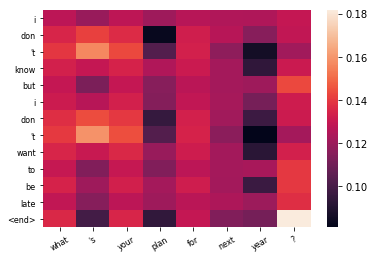

In [78]:
df = pd.DataFrame(attns[:len(response)].tolist(), index=response, columns=context.split())
f = sns.heatmap(df)
f.set_xticklabels(f.get_xticklabels(), rotation=30, fontsize=8)
f.set_yticklabels(f.get_yticklabels(), fontsize=8)

In [79]:
f.get_figure().savefig("attention_figures/attention-3.png", dpi=1200)

In [ ]:
def greedy(test_loader, encoder, decoder, sample, use_cuda):
    with torch.no_grad():
        stats = torch.zeros(8)
        c_acc, r_acc = 0, 0
        count = Counter([])
        count2 = Counter([])
        with progressbar.ProgressBar(max_value=len(test_loader)) as bar:
            for batch_id ,(source, source_lens, target, target_lens)in enumerate(test_loader):
                bar.update(batch_id)
                source, target = Variable(source), Variable(target)
                if use_cuda: source, target = source.cuda(), target.cuda()
                batch_size = source.size()[1]
                encoder_outputs, encoder_last_hidden = encoder(source, source_lens, None)
                max_target_len = max(target_lens)
                decoder_hidden = encoder_last_hidden
                target_slice = Variable(torch.zeros(batch_size).fill_(test_data.target_vocab.SOS).long())
                pred_seq = torch.zeros_like(target.data)
                pred_lens = torch.ones(batch_size).byte()
                end = torch.zeros(batch_size).byte()
                attns = torch.zeros(batch_size, max_target_len, source_lens[0])
                if use_cuda:
                    source, target = source.cuda(), target.cuda()
                    target_slice = target_slice.cuda()
                    pred_seq = pred_seq.cuda()
                    end = end.cuda()
                    pred_lens = pred_lens.cuda()
                for l in range(max_target_len):
                    predictions, decoder_hidden, atten_scores = decoder(target_slice,
                                                                        encoder_outputs,
                                                                        source_lens,
                                                                        decoder_hidden)
                    attns[:, l, :] = atten_scores.squeeze(1)
                    if not sample:
                        pred_words = predictions.data.topk(2, 1)[1]
                        first = pred_words[:, 0]
                        second = pred_words[:, 1]
                        pred_words = torch.where(first == test_data.target_vocab.UNK, second, first)
                        pred_seq[l] = pred_words
                    else:
                        predictions[:, 0] = 0 # do not sample UNK
                        prob = torch.cumsum(softmax(predictions), 1)
                        dice = torch.rand(batch_size).unsqueeze(1)
                        if use_cuda: dice = dice.cuda()
                        prob -= dice
                        prob = prob > 0
                        pred_words = torch.zeros(batch_size).long()
                        if use_cuda: pred_words = pred_words.cuda()
                        for i in range(batch_size):
                            first = prob[i, :].nonzero()[0]
                            pred_words[i] = first
                        pred_seq[l] = pred_words
                    target_slice = Variable(pred_words)
                    eos = torch.eq(pred_seq[l], test_data.target_vocab.EOS)
                    end = (end + eos.cuda())>0
                    pred_lens += (end == 0)
                for i in range(batch_size):
                    pred_sen = pred_seq[:pred_lens[i]-1, i]
                    count.update(pred_sen.tolist())
                    count2.update([tuple(pred_sen.tolist()[i:i+2]) for i in range(len(pred_sen.tolist())-1)])
                s, c, r = get_stats(pred_seq.cpu(), pred_lens.tolist(), target.data.cpu(), target_lens, 4)
                stats += s
                c_acc += c
                r_acc += r
                for i in range(batch_size):
#                     if test_data.target_vocab.UNK in source.data[:source_lens[i], i]: continue
                    print("Given source sequence:\n {}".format(vocab.to_text(source.data[:source_lens[i], i])))
                    print("target sequence is:\n {}".format(vocab.to_text(target.data[:target_lens[i], i])))
                    print("greedily decoded sequence is:\n {}".format(vocab.to_text(pred_seq[:pred_lens[i], i])))
                    print("attention scores is: \n {}".format(attns[i, :, :]))
                raise NotImplementedError
            bleus = []
            distinct1 = len(count.keys())/sum(count.values())
            print("total words are {}, total 2-grams are {}".format(sum(count.values()), sum(count2.values())))
            distinct2 = len(count2.keys())/sum(count2.values())
            for i in range(1,5):
                bleus.append(compute_bleu(i, c_acc, r_acc, stats[0:2*i]))
            return bleus, distinct1, distinct2
            

In [ ]:
bleus, distinct1, distinct2 = greedy(test_loader, encoder, decoder, False, True)
bleus, distinct1, distinct2

In [ ]:
A = Tensor([0.1, 0.2, 0.3, 0.4, 0.2])
torch.cumsum(A, 0)

In [13]:
class Beam():
    def __init__(self, beam_size, vocab, alpha, n_best, use_cuda, intra=0, repeat=0):
        self.beam_size = beam_size
        self.vocab = vocab
        self.alpha = alpha
        self.n_best = n_best

        self.prevs = [] # pointer to sequence in beam
        self.nexts = [torch.zeros(beam_size).fill_(vocab.SOS)]
        if use_cuda: self.nexts = [t.cuda() for t in self.nexts]
        self.attns = []
        self.scores = torch.zeros(beam_size)
        self.all_scores = []
        if use_cuda: self.scores = self.scores.cuda()
        self.finished = [] # list of tuples, (index within beam, output index, score)
        self.stop = False
        self.cuda = use_cuda
        self.intra = intra
        assert 0 <= repeat <= 5
        self.repeat = repeat

    def get_last_words(self):
        return self.nexts[-1]

    def get_last_root(self):
        return self.prevs[-1]

    
    def get_pred(self, word_idx, beam_idx):
        pred = []
        attn = []
        for i in range(len(self.prevs[:beam_idx]), -1, -1):
            pred.append(self.nexts[i][word_idx].item())
            attn.append(self.attns[i-1][word_idx])
            word_idx = self.prevs[i-1][word_idx]
        attn.reverse()
        pred.reverse()
        return pred, torch.stack(attn)
    
    def advance(self, logits, attn):
        """
        Args:
        `logits`: log probability of each candidate sequence for generating next word, beam_size x vocab_size
        `attn`: attention vectors of decoder
        """
        has_repeat = False
        if len(self.prevs) == 0:
            beam_scores = logits[0]
        else:
            c = Counter()
            penal = []
            # intra-sibling penalization
            for i in range(len(self.prevs[-1])):
                c[self.prevs[-1][i]]+=1
                penal.append(c[self.prevs[-1][i]]-1)
            penal = Tensor(penal).cuda() if self.cuda else Tensor(penal)
            penal *= self.intra
            self.scores -= penal
            beam_scores = self.scores.unsqueeze(1).expand_as(logits) + logits
            for i in range(self.nexts[-1].size(0)):
                if self.nexts[-1][i] == self.vocab.EOS or self.nexts[-1][i] == self.vocab.UNK:
                    beam_scores[i] = -1e20
                if self.repeat > 0: 
                    hyp, _ = self.get_pred(len(self.nexts)-1, i)
                    ngrams = [tuple(hyp[j:j+self.repeat]) for j in range(len(hyp)+1-self.repeat)]
                    c = Counter(ngrams)
                    has_repeat = np.any(np.array(list(c.values())) > 1)
                    if has_repeat: 
                        vocab.to_text(hyp)
                        beam_scores[i] = -1e20

        flat_beam_scores = beam_scores.view(-1)
        best_scores, best_word_id = flat_beam_scores.topk(self.beam_size, 0, True, True)
        self.all_scores.append(self.scores)
        self.scores = best_scores
        prev = best_word_id / self.vocab.vocab_size
        prev = prev.data.long()
        self.prevs.append(prev)
        next_idx = (best_word_id % self.vocab.vocab_size).data.long()
        if next_idx.is_cuda: next_idx = next_idx.cpu()
        self.nexts.append(next_idx)
        self.attns.append(attn.index_select(0, prev))
        for idx, word_idx in enumerate(self.nexts[-1]):
            if word_idx == self.vocab.EOS:
                self.finished.append((idx, len(self.nexts)-1, (self.scores.data[idx])/(len(self.nexts)-1)))
        if self.nexts[-1][0] == self.vocab.EOS:
            self.all_scores.append(self.scores)
            self.stop = True

    def topk(self, k):
        """
        If this beam has finished searching, get the top k best sequence. If there are less than k completed sentences,
        add partial sentences.
        """
        self.finished.sort(key=lambda x : -x[2]) #TODO: Check why this is inverse
        scores = [s for _, _, s in self.finished]
        print("Total number of candidates are {}".format(len(self.finished)))
        idx = [(word_idx, beam_idx) for (word_idx, beam_idx, _) in self.finished[0:k]]
        makeup = k-len(idx)
        for i, (score, word_idx) in enumerate(zip(self.scores, self.nexts[-1])):
            if i > makeup -1: continue
            scores.append(score/(len(self.nexts)-1))
            idx.append((i, len(self.nexts)-1))

        preds = [self.get_pred(*x) for x in idx]
        sentences, attns = zip(*preds)
        return sentences, attns

In [ ]:
def beam_search(encoder, decoder, test_loader, beam_size, vocab, alpha, n_best, 
                encoder_reverse=None, decoder_reverse=None, intra=0, repeat=3):
    with torch.no_grad():
        stats = torch.zeros(8)
        c_acc, r_acc = 0, 0
        count = Counter([])
        count2 = Counter([])
        with progressbar.ProgressBar(max_value=len(test_loader)) as bar:
            for batch_id ,(source, source_lens, target, target_lens)in enumerate(test_loader):
                bar.update(batch_id)
                source, target = Variable(source), Variable(target)
                if args.cuda: source, target = source.cuda(), target.cuda()
                batch_size = source.size()[1]
                encoder_outputs, encoder_last_hidden = encoder(source, source_lens, None)
                decoder_hidden = encoder_last_hidden
                make_beam = lambda : Beam(beam_size, vocab, alpha, n_best, args.cuda, intra, repeat)
                beams = [make_beam() for _ in range(batch_size)]
                decoder_hidden = (decoder_hidden[0].repeat(1,beam_size,1), decoder_hidden[1].repeat(1,beam_size,1))
                encoder_outputs = encoder_outputs.repeat(1,beam_size,1)
                source_lens = torch.LongTensor(source_lens).repeat(1,beam_size,1).view(-1).tolist()
                pred_seq = torch.zeros(30, target.size()[1]).long()
                pred_lens = []
                for l in range(args.global_max_target_len):
                    last_words = torch.stack([b.get_last_words() for b in beams])
                    last_words = Variable(last_words).t().contiguous().view(1, -1).squeeze(0).long()
                    if args.cuda: last_words = last_words.cuda()
                    logits, decoder_hidden, atten_scores = decoder(last_words,
                                                                        encoder_outputs,
                                                                        source_lens,
                                                                        decoder_hidden)
                    logits = log_softmax(logits, 1)
                    logits = logits.view(beam_size, batch_size, -1)
                    atten_scores = atten_scores.view(beam_size, batch_size, -1)

                    for j, b in enumerate(beams):
                        b.advance(logits[:, j], atten_scores.data[:, j])
                        last_roots = b.get_last_root()
                        for d in decoder_hidden:
                            layer_size = d.size(0)
                            beam_batch = d.size(1)
                            hidden_size = d.size(2)
                            sent_states = d.view(layer_size, beam_size, beam_batch // beam_size,
                                    hidden_size)[:, :, j]
                            sent_states.data.copy_(sent_states.data.index_select(1, last_roots))
                for i in range(batch_size):
                    pred, _ = beams[i].topk(n_best)
                    if encoder_reverse is None or decoder_reverse is None:
                        pred_sen = torch.LongTensor(pred[0][1:])
                    else:
                        beam_first = pred[0][1:]
                        pred_lens = [len(i[1:]) for i in pred]
                        total = min(len(pred), n_best)
                        pred_source = torch.zeros(max(pred_lens), total).long()
                        for idx, p in enumerate(pred):
                            pred_source[:pred_lens[idx], idx] = torch.LongTensor(p[1:])
                        pred_source = Variable(pred_source)
                        if args.cuda: pred_source = pred_source.cuda()
                        sorted_idx = np.argsort(pred_lens)
                        sorted_idx = sorted_idx[::-1].tolist()
                        pred_source = pred_source[:, sorted_idx]
                        pred_lens = [pred_lens[i] for i in sorted_idx]
                        encoder_reverse_outputs, encoder_reverse_last_hidden = encoder_reverse(pred_source, pred_lens, None)
                        decoder_reverse_hidden = encoder_reverse_last_hidden
                        loss = torch.zeros(total)
                        last_words = Variable(torch.zeros(total).fill_(vocab.SOS).long())
                        if args.cuda: 
                            last_words = last_words.cuda()
                            loss = loss.cuda()
                        for l in range(source_lens[i]):
                            logits, decoder_reverse_hidden, _ = decoder_reverse(last_words, 
                                                                               encoder_reverse_outputs,
                                                                               pred_lens,
                                                                               decoder_reverse_hidden)
                            logits = log_softmax(logits, 1)
                            loss += logits[:, source[:, i][l]]
                            last_words = source[:, i][l].expand_as(last_words)
                        _, best_idx = torch.max(loss, 0)
                        pred_sen = pred_source[:, best_idx][0:pred_lens[best_idx]]
                        pred_sen = pred_sen.cpu()
                    count.update(pred_sen.tolist()[:-1])
                    count2.update([tuple(pred_sen.tolist()[i:i+2]) for i in range(len(pred_sen)-2)])
                    pred_seq[0:len(pred_sen), i] = pred_sen
                    pred_lens.append(len(pred_sen))
                    print("Given source sequence:\n {}".format(vocab.to_text(source.data[:source_lens[i], i])))
                    print("target sequence is:\n {}".format(vocab.to_text(target.data[:target_lens[i], i])))
                    print("MMI sequence was the {}th sentence in beam, and it is:\n {}".format(
                        sorted_idx[best_idx], vocab.to_text(pred_sen)))
                    print("First sentence in beam, and it is:\n {}".format(vocab.to_text(beam_first)))
#                     print("beam search sequence is:")
#                     for i in range(n_best):
#                         print("{}. {}".format(i, vocab.to_text(pred[i])))
                    raise NotImplementedError
                s, c, r = get_stats(pred_seq.cpu(), pred_lens, target.data.cpu(), target_lens, 4)
                stats += s
                c_acc += c
                r_acc += r

        bleus = []
        distinct1 = len(count.keys())/sum(count.values())
        distinct2 = len(count2.keys())/sum(count2.values())
        print("total words are {}, total 2-grams are {}".format(sum(count.values()), sum(count2.values())))
        for i in range(1,5):
            bleus.append(compute_bleu(i, c_acc, r_acc, stats[0:2*i]))
        return bleus, distinct1, distinct2


In [ ]:
# bleus, distinct1, distinct2 = greedy(test_loader, encoder, decoder, args.cuda)
bleus, distinct1, distinct2 = beam_search(encoder, decoder, test_loader, 200, vocab, 0, 1000, 
                                          encoder_reverse, decoder_reverse, 0, 0)
print("MMI")
print(bleus, distinct1, distinct2)
# bleus, distinct1, distinct2 = beam_search(encoder, decoder, test_loader, 200, vocab, 0, 200, 
#                                           None, None, 0, 0)


In [ ]:
print("Beam200")
print(bleus, distinct1, distinct2)
bleus, distinct1, distinct2 = beam_search(encoder, decoder, test_loader, 200, vocab, 0, 200, 
                                          None, None, 1, 0)
print("Intra")
print(bleus, distinct1, distinct2)

In [ ]:
vocab.to_text([5, 32, 13, 46])

In [ ]:
bleus, distinct1, distinct2

In [ ]:
print(bleu2)

In [ ]:
l = [1, 1, 2, 3, 2]
c = Counter()
p = []
for i in range(len(l)):
    c[l[i]]+=1
    p.append(c[l[i]]-1)
p